In [ ]:
#import sklearn 
#print('The version of sklearn is {}'.format(sklearn.__version__))
#!pip uninstall scikit-learn
#!pip install scikit-learn==0.20.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cat '/content/drive/MyDrive/Colab Notebooks/equal_groups.ipynb'
!cat '/content/drive/MyDrive/Colab Notebooks/equal_grouping.py'

{"nbformat":4,"nbformat_minor":0,"metadata":{"colab":{"name":"equal_groups.ipynb","provenance":[],"collapsed_sections":[],"authorship_tag":"ABX9TyM8T/L7MdrXE+orBjAjSa8g"},"kernelspec":{"name":"python3","display_name":"Python 3"},"language_info":{"name":"python"}},"cells":[{"cell_type":"code","metadata":{"id":"s3iNcHcIfCc8"},"source":["\"\"\"Equal Groups K-Means clustering utlizing the scikit-learn api and related\n","utilities.\n","\n","BSD 3-clause \"New\" or \"Revised\" License\n","\n","version 0.17.1\n","\"\"\"\n","\n","\n","import warnings\n","\n","import numpy as np\n","import scipy.sparse as sp\n","\n","from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin\n","#from sklearn.cluster import KMeans\n","from sklearn.cluster import k_means_\n","from sklearn.cluster import _k_means\n","from sklearn.externals.joblib import Parallel\n","from sklearn.externals.joblib import delayed\n","from sklearn.metrics.pairwise import euclidean_distances\n","from sklearn.utils.extmath

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
assert sys.version_info >= (3, 5)
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from sklearn.cluster import KMeans
#from equal_grouping import EqualGroupsKMeans
from equal_grouping import EqualGroupsKMeans

np.random.seed(42)
tf. random.set_seed(42)

In [ ]:
M = 16
k = int(np.log2(M))
n = 16
training_snr = 20 #SNR Bob in dB
sample_size = 20_000
groups = 4
M_sec = 4

# PREPARING DATA FOR TRAINING AND TESTING

messages = np.random.randint(M, size= sample_size)
messages_2 = np.random.randint(M, size= sample_size)
messages_3 = np.random.randint(M, size= sample_size)

one_hot_encoder = OneHotEncoder(categories=[range(M)], sparse=False)
data_oneH = one_hot_encoder.fit_transform(messages.reshape(-1,1))
data_oneH_2 = one_hot_encoder.fit_transform(messages_2.reshape(-1,1))
data_oneH_3 = one_hot_encoder.fit_transform(messages_3.reshape(-1,1))

# date_try = one_hot_encoder.fit_transform(np.random.randint(M, size=3).reshape(-1, 1))
# print(date_try)

In [ ]:
## Function converts SNR(dB) to SNR ad eventually computes NOISE

def snr_to_noise(snrdb):
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [ ]:
# CONSTRUCTING LAYERS FOR THE AUTOENCODERS OF BOB AND EVE

noise_std = snr_to_noise(training_snr)
noise_std_eve = snr_to_noise(2)
noise_std2  = snr_to_noise(0)
noise_std3  = snr_to_noise(0)
# custom functions to represent layers without weights

norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))

channel_layer = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
channel_layer2 = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std2)))
channel_layer3 = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std3)))

channel_layer_eve = keras.layers.Lambda(lambda x: tf.add(x, tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std_eve)))

# ENCODER_1
encoder_1 = keras.models.Sequential([
                                   keras.layers.InputLayer(input_shape=[M]),
                                   keras.layers.Dense(M, activation='elu'),
                                   keras.layers.Dense(2*n, activation=None),
                                   shape_layer,
                                   norm_layer])

# ENCODER_2
encoder_2 = keras.models.Sequential([
                                     keras.layers.InputLayer(input_shape=[M]),
                                     keras.layers.Dense(M, activation='elu'),
                                     keras.layers.Dense(2*n, activation=None),
                                     shape_layer,
                                     norm_layer])

# ENCODER_3
encoder_3 = keras.models.Sequential([
                                     keras.layers.InputLayer(input_shape=[M]),
                                     keras.layers.Dense(M, activation='elu'),
                                     keras.layers.Dense(2*n, activation=None),
                                     shape_layer,
                                     norm_layer])


# CHANNELS WITH NOISE
channel_1 = keras.models.Sequential([channel_layer, channel_layer2, channel_layer3])
channel_2 = keras.models.Sequential([channel_layer2, channel_layer, channel_layer3])
channel_3 = keras.models.Sequential([channel_layer2, channel_layer, channel_layer3])

#channel = keras.models.Sequential([channel_layer])
channel_eve_1 = keras.models.Sequential([channel_1, channel_layer_eve])
channel_eve_2 = keras.models.Sequential([channel_2, channel_layer_eve])
channel_eve_3 = keras.models.Sequential([channel_3, channel_layer_eve])

# DECODER DESIGN
decoder_bob = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

decoder_eve = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

decoder_bob_2 = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])

decoder_eve_2 = keras.models.Sequential([
                                       keras.layers.InputLayer(input_shape=[2,n]),
                                       shape_layer2,
                                       keras.layers.Dense(M, activation='elu'),
                                       keras.layers.Dense(M, activation= 'softmax')])


# AUTOENCODER DESIGN
autoencoder_input1 = keras.models.Sequential([encoder_1, channel_1, decoder_bob])
autoencoder_input2 = keras.models.Sequential([encoder_2, channel_2, decoder_bob_2])
autoencoder_input3 = keras.models.Sequential([encoder_3, channel_3, decoder_bob_3])

# AUTOENCODER DESIGN
autoencoder_input_1 = keras.models.Sequential([encoder_1, channel_1, decoder_bob])
autoencoder_input_2 = keras.models.Sequential([encoder_2, channel_2, decoder_bob])
autoencoder_input_3 = keras.models.Sequential([encoder_3, channel_3, decoder_bob])

autoencoder_eve_1 = keras.models.Sequential([encoder_1, channel_eve_1, decoder_eve])
autoencoder_eve_2 = keras.models.Sequential([encoder_2, channel_eve_2, decoder_eve])
autoencoder_eve_3 = keras.models.Sequential([encoder_3, channel_eve_3, decoder_eve])


autoencoderinput_1 = keras.models.Sequential([encoder_1, channel_1, decoder_bob_2])
autoencoderinput_2 = keras.models.Sequential([encoder_2, channel_2, decoder_bob_2])
autoencoderinput_3 = keras.models.Sequential([encoder_3, channel_3, decoder_bob_2])

autoencodereve_1 = keras.models.Sequential([encoder_1, channel_eve_1, decoder_eve_2])
autoencodereve_2 = keras.models.Sequential([encoder_2, channel_eve_2, decoder_eve_2])
autoencodereve_3 = keras.models.Sequential([encoder_3, channel_eve_3, decoder_eve_2])

In [ ]:
## FUNCTION TO RANDOMLY GIVE US A RANDOM BATCH OF OUR TRAIN DATA

def random_batch(X, batch_size = 32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx]

In [ ]:
# UNSECURED TRAINING PARAMETERS

n_epochs = 5
batch_size = 200
n_steps = len(data_oneH) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.006) ########## was 0.006
loss_fn = keras.losses.categorical_crossentropy
mean_loss = keras.metrics.Mean()

In [ ]:
## BER CALCULATOR

def B_Ber(input_msg, msg):
    pred_error = tf.not_equal(tf.argmax(msg,1), tf.argmax(input_msg,1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [ ]:
## PLOT TO TEST ENCODING RESULTS

def test_encoding(M=16, n=1):
    inp = np.eye(M, dtype=int)
    inp_2 = np.eye(M, dtype=int)
    inp_3 = np.eye(M, dtype=int)
    coding_1 = encoder_1.predict(inp)
    coding_2 = encoder_2.predict(inp_2)
    coding_3 = encoder_3.predict(inp_3)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding_1[:,0], coding_1[:,1], 'b.')
    plt.plot(coding_2[:,0], coding_2[:,1], '*r')
    plt.plot(coding_3[:,0], coding_3[:,1], '*g')
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [ ]:
## PLOT FOR NOISY RECEIVED

def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:,1], 'b.')
    #plt.plot(rcvd_word_eve[:,0], rcvd_word_eve[:,1], 'b.')
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [ ]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 100 == 0:
        print(template.format(step, epoch, mean_loss, B_Ber(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [ ]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss, B_Ber(X_batch, y_pred)))

In [ ]:
# TRAINING 3 INPUTS TOGETHER Bob

def train_both_setups(n_epochs=5, n_steps=20, alpha1=0.4, alpha2=0.5, alpha3=0.1, plot_encoding=True, only_decoder = False):
    for epoch in range(1, n_epochs+1):
       
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)
            X_batch_3 = random_batch(data_oneH_3, batch_size)

            with tf.GradientTape() as tape:
                y_pred_1 = autoencoder_input1(X_batch_1, training=True)
                y_pred_2 = autoencoder_input2(X_batch_2, training=True)
                y_pred_3 = autoencoder_input3(X_batch_3, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))
                loss_3 = tf.reduce_mean(loss_fn(X_batch_3, y_pred_3))

                loss_eqn = alpha1*loss_1 + alpha2*loss_2 + alpha3*loss_3
               

            if only_decoder: 
                gradients = tape.gradient(loss_eqn, decoder_bob.trainable_variables + decoder_bob_2.trainable_variables )
                optimizer.apply_gradients(zip(gradients, decoder_bob.trainable_variables + decoder_bob_2.trainable_variables))

            else:
                 gradient = tape.gradient(loss_eqn, autoencoder_input1.trainable_variables + autoencoder_input2.trainable_variables + autoencoder_input3.trainable_variables)
                 optimizer.apply_gradients(zip(gradient, autoencoder_input1.trainable_variables + autoencoder_input2.trainable_variables + autoencoder_input3.trainable_variables))
              
            mean_loss = (loss_eqn)
            
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)

In [ ]:
# TRAINING 3 INPUTS TOGETHER Bob

def train_both_inputs_bob(n_epochs=5, n_steps=20, alpha1=0.5, alpha2=0.5, alpha3=0.5, plot_encoding=True, only_decoder = False):
    for epoch in range(1, n_epochs+1):
       
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)
            X_batch_3 = random_batch(data_oneH_3, batch_size)

            with tf.GradientTape() as tape:
                y_pred_1 = autoencoder_input_1(X_batch_1, training=True)
                y_pred_2 = autoencoder_input_2(X_batch_2, training=True)
                y_pred_3 = autoencoder_input_3(X_batch_3, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))
                loss_3 = tf.reduce_mean(loss_fn(X_batch_3, y_pred_3))

                loss_eqn = alpha1*loss_1 + alpha2*loss_2 + alpha3*loss_3
               

            if only_decoder: 
                gradients = tape.gradient(loss_eqn, decoder_bob.trainable_variables)
                optimizer.apply_gradients(zip(gradients, decoder_bob.trainable_variables))

            else: #This assumes interference setup
                 gradient = tape.gradient(loss_eqn, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables + autoencoder_input_3.trainable_variables)
                 optimizer.apply_gradients(zip(gradient, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables + autoencoder_input_3.trainable_variables))
              
            mean_loss = (loss_eqn)
            
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)



In [ ]:
# TRAINING 2 INPUTS TOGETHER EVE

def train_both_inputs_eve(n_epochs=5, n_steps=20, plot_encoding=True, alpha1=0.5, alpha2=0.5, alpha3=0.5):
    for epoch in range(1, n_epochs+1):
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))

        
        for step in range(1, n_steps+1):
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)
            X_batch_3 = random_batch(data_oneH_3, batch_size)

            with tf.GradientTape() as tape:                
                y_pred_1 = autoencoder_eve_1(X_batch_1, training=True)
                y_pred_2 = autoencoder_eve_2(X_batch_2, training=True)
                y_pred_3 = autoencoder_eve_3(X_batch_3, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))
                loss_3 = tf.reduce_mean(loss_fn(X_batch_3, y_pred_3))

                loss_eqn = alpha1*loss_1 + alpha2*loss_2 + alpha3*loss_3


            gradients = tape.gradient(loss_eqn, decoder_eve.trainable_variables)
            optimizer.apply_gradients(zip(gradients, decoder_eve.trainable_variables))


            mean_loss = (loss_eqn)
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)


In [ ]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve (ENCODER 1)

def Test_AE(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_1.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)


    return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)


In [ ]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve (ENCODER 2)

def Test_AE_2(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_2 = [None] * len(snr_range)
    bber_vec_eve_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_2.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

        bber_vec_bob_2[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_2[db] = B_Ber(data, dcoded_msg_eve)


    return (snr_range, bber_vec_bob_2), (snr_range, bber_vec_eve_2)

In [ ]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve (ENCODER 2)

def Test_AE_3(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_3 = [None] * len(snr_range)
    bber_vec_eve_3 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_3.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

        bber_vec_bob_3[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_3[db] = B_Ber(data, dcoded_msg_eve)


    return (snr_range, bber_vec_bob_3), (snr_range, bber_vec_eve_3)

In [ ]:
# Test Data for Unsecured Encoding #This data is used to plot BER# Paper plots for only 1 of the autoencoders.

N_test = 150_000
test_msg = np.random.randint(M, size=N_test)
test_msg_2 = np.random.randint(M, size=N_test)
test_msg_3 = np.random.randint(M, size=N_test)

one_hot_encoder = OneHotEncoder(sparse=False, categories = [range(M)])
data_normal = one_hot_encoder.fit_transform(test_msg.reshape(-1,1))
data_normal_2 = one_hot_encoder.fit_transform(test_msg_2.reshape(-1,1))
data_normal_3 = one_hot_encoder.fit_transform(test_msg_3.reshape(-1,1))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https:/

Training Both inputs in Epochs 1/5
Iteration: 100, Epoch: 1, Loss: 2.34975, Batch_BER: 0.03500


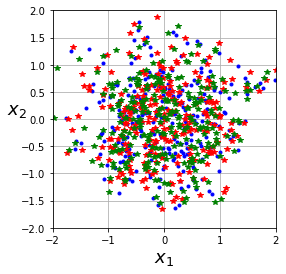

Training Both inputs in Epochs 2/5
Iteration: 100, Epoch: 2, Loss: 2.13989, Batch_BER: 0.04000


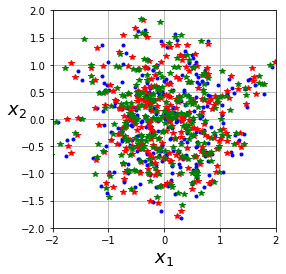

Training Both inputs in Epochs 3/5
Iteration: 100, Epoch: 3, Loss: 2.43102, Batch_BER: 0.04000


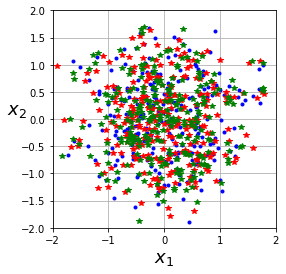

Training Both inputs in Epochs 4/5
Iteration: 100, Epoch: 4, Loss: 1.32932, Batch_BER: 0.02000


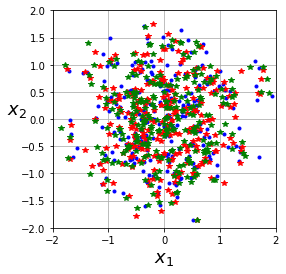

Training Both inputs in Epochs 5/5
Iteration: 100, Epoch: 5, Loss: 1.46994, Batch_BER: 0.03500


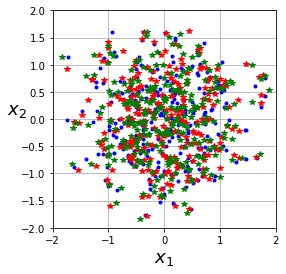

Training Both inputs in Epochs 1/5
Iteration: 100, Epoch: 1, Loss: 3.85340, Batch_BER: 0.07000


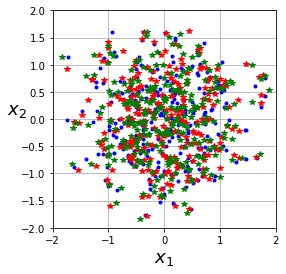

Training Both inputs in Epochs 2/5
Iteration: 100, Epoch: 2, Loss: 2.74919, Batch_BER: 0.09500


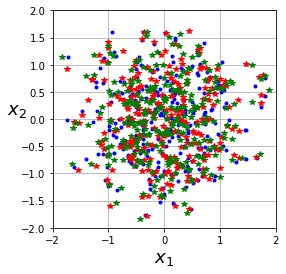

Training Both inputs in Epochs 3/5
Iteration: 100, Epoch: 3, Loss: 3.26544, Batch_BER: 0.06500


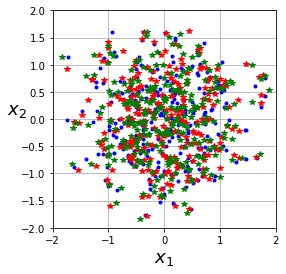

Training Both inputs in Epochs 4/5
Iteration: 100, Epoch: 4, Loss: 2.18544, Batch_BER: 0.06500


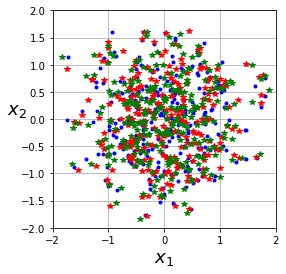

Training Both inputs in Epochs 5/5
Iteration: 100, Epoch: 5, Loss: 2.33954, Batch_BER: 0.07000


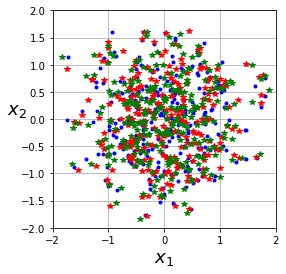

In [ ]:
#TRAINING BOB AND EVE AND TESTING #############################################

#train_both_setups(n_epochs, n_steps=20, alpha1=10, alpha2=10, alpha3=10,  plot_encoding=False, only_decoder = False)

train_both_inputs_bob(n_epochs, n_steps, alpha1=6, alpha2=6, alpha3=6, plot_encoding = True, only_decoder = False)
train_both_inputs_eve(n_epochs, n_steps, plot_encoding = True, alpha1=4, alpha2=4, alpha3=4)
bber_data_bob, bber_data_eve = Test_AE(data_normal)
bber_data_bob_2, bber_data_eve_2 = Test_AE_2(data_normal_2)
bber_data_bob_3, bber_data_eve_3 = Test_AE_3(data_normal_3) 

In [ ]:

# KMEANS FROM EQUAL SIZE PY MODULE

def new_kmeans(M=16, groups=4, n=100):
    inp = np.eye(M, dtype=int)
    unit_codewords = encoder_1.predict(inp)
    kmeans = EqualGroupsKMeans(n_clusters=groups)
    kmeans.fit(unit_codewords.reshape(M, 2*n))
    return kmeans

def new_kmeans2(M=16, groups=4, n=100):
    inp_2 = np.eye(M, dtype=int)
    unit_codewords_2 = encoder_2.predict(inp_2)
    kmeans2 = EqualGroupsKMeans(n_clusters=groups)
    kmeans2.fit(unit_codewords_2.reshape(M, 2*n)) 
    return kmeans2

def new_kmeans3(M=16, groups=4, n=100):
    inp_3 = np.eye(M, dtype=int)
    unit_codewords_3 = encoder_3.predict(inp_3)
    kmeans3 = EqualGroupsKMeans(n_clusters=groups)
    kmeans3.fit(unit_codewords_3.reshape(M, 2*n)) 
    return kmeans3

In [ ]:
# Generation of Secured Matrix using kmeans_labels from new file

def secure_matrix(kmeans_labels, groups=4, M=16):
    sec_matrix = np.zeros((M,M))
    for j in range(groups):
        for i in range(M):
            if kmeans_labels[i]==j:
                for k in range(M):
                    if kmeans_labels[k] == j:
                        sec_matrix[i,k] = 1/groups;
    sec_matrix=tf.cast(sec_matrix, tf.float64)
    return sec_matrix

def secure_matrix2(kmeans2_labels, groups=4, M=16):
    sec_matrix2 = np.zeros((M,M))
    for j in range(groups):
        for i in range(M):
            if kmeans2_labels[i]==j:
                for k in range(M):
                    if kmeans2_labels[k] == j:
                        sec_matrix2[i,k] = 1/groups;
    sec_matrix2=tf.cast(sec_matrix2, tf.float64)
    return sec_matrix2

def secure_matrix3(kmeans3_labels, groups=4, M=16):
    sec_matrix3 = np.zeros((M,M))
    for j in range(groups):
        for i in range(M):
            if kmeans3_labels[i]==j:
                for k in range(M):
                    if kmeans3_labels[k] == j:
                        sec_matrix3[i,k] = 1/groups;
    sec_matrix3=tf.cast(sec_matrix3, tf.float64)
    return sec_matrix3

In [ ]:
# SECURED TRAINING FOR MULTIPLE INPUTS (2)

def train_Secure(kmeans_labels, kmeans2_labels, kmeans3_labels, n_epochs=5, n_steps=20, eps1=0.7, eps2=0.7, beta1=0.7, beta2=0.7, beta3=0.7, gamma1=0.2, gamma2=0.2, gamma3=0.2, plot_encoding=True):

    sec_matrix = secure_matrix(kmeans_labels, groups=4, M=16)
    sec_matrix2 = secure_matrix2(kmeans2_labels, groups=4, M=16)
    sec_matrix3 = secure_matrix3(kmeans3_labels, groups=4, M=16)

    for epoch in range(1, n_epochs+1):
        print('Trainig for Secrecy in Epochs: {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            x_batch_1 = random_batch(data_oneH, batch_size)
            x_batch_s_1 = tf.matmul(x_batch_1, sec_matrix)

            x_batch_2 = random_batch(data_oneH_2, batch_size)
            x_batch_s_2 = tf.matmul(x_batch_2, sec_matrix2)

            x_batch_3 = random_batch(data_oneH_3, batch_size)
            x_batch_s_3 = tf.matmul(x_batch_3, sec_matrix3)

            with tf.GradientTape() as tape:
                y_pred_bob_1 = autoencoder_input_1(x_batch_1, training=True)
                y_pred_eve_1 = autoencoder_eve_1(x_batch_s_1, training=True)

                y_pred_bob_2 = autoencoder_input_2(x_batch_2, training=True)
                y_pred_eve_2 = autoencoder_eve_2(x_batch_s_2, training=True)

                y_pred_bob_3 = autoencoder_input_3(x_batch_3, training=True)
                y_pred_eve_3 = autoencoder_eve_3(x_batch_s_3, training=True)

                loss_bob_1 = tf.reduce_mean(loss_fn(x_batch_1, y_pred_bob_1))    
                loss_eve_1 = tf.reduce_mean(loss_fn(x_batch_s_1, y_pred_eve_1))

                loss_bob_2 = tf.reduce_mean(loss_fn(x_batch_2, y_pred_bob_2))
                loss_eve_2 = tf.reduce_mean(loss_fn(x_batch_s_2, y_pred_eve_2))

                loss_bob_3 = tf.reduce_mean(loss_fn(x_batch_3, y_pred_bob_3))
                loss_eve_3 = tf.reduce_mean(loss_fn(x_batch_s_3, y_pred_eve_3))

                loss_sec =  (eps1)*(beta1*loss_bob_1 + beta2*loss_bob_2 + beta3*loss_bob_3) + eps2*(gamma1*loss_eve_1 + gamma2*loss_eve_2 + gamma3*loss_eve_3)

            gradients = tape.gradient(loss_sec, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables + autoencoder_input_3.trainable_variables) 
            optimizer.apply_gradients(zip(gradients, autoencoder_input_1.trainable_variables + autoencoder_input_2.trainable_variables + autoencoder_input_3.trainable_variables)) 

            mean_loss(loss_sec)
            plot_loss(step, epoch, mean_loss, x_batch_1, y_pred_bob_1, plot_encoding)


In [ ]:
# Used to Calculate BER FOR EVERY SNR AFTER SECURED TRAINING (encoder_1)
def Test_Secure_AE(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(1)
        code_word = encoder_1.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)

In [ ]:
# Used to Calculate BER FOR EVERY SNR AFTER SECURED TRAINING (encoder_2)

def Test_Secure_AE_2(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_2 = [None] * len(snr_range)
    bber_vec_eve_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(1)
        code_word = encoder_2.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

        bber_vec_bob_2[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_2[db] = B_Ber(data, dcoded_msg_eve)


    return (snr_range, bber_vec_bob_2), (snr_range, bber_vec_eve_2)

In [ ]:
# Used to Calculate BER FOR EVERY SNR AFTER SECURED TRAINING (encoder_2)

def Test_Secure_AE_3(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_3 = [None] * len(snr_range)
    bber_vec_eve_3 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(1)
        code_word = encoder_3.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve.predict(rcvd_word_eve)

        bber_vec_bob_3[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_3[db] = B_Ber(data, dcoded_msg_eve)


    return (snr_range, bber_vec_bob_3), (snr_range, bber_vec_eve_3)

In [ ]:
#TRAINING BOB AND EVE AND TESTING ~ USING modified KMEANS 

kmeans = new_kmeans(M, groups,n)
kmeans2 = new_kmeans2(M, groups, n)
kmeans3 = new_kmeans3(M, groups, n)

#train_Secure(kmeans.labels_, kmeans2.labels_, n_epochs-3, n_steps=20, eps=0.9, beta=0.7, gamma=0.8, plot_encoding=True) # Initial values were 0.9, 0.8, 0.8 beta at 0.6 was pretty cool
train_Secure(kmeans.labels_, kmeans2.labels_, kmeans3.labels_, n_epochs=5, n_steps=20, eps1=1, eps2=10, beta1=6, beta2=6, beta3=6, gamma1=10, gamma2=10, gamma3=10, plot_encoding=True)
train_both_inputs_bob(n_epochs-2, n_steps, alpha1=6, alpha2=6, alpha3=6, plot_encoding = False, only_decoder = True)
train_both_inputs_eve(n_epochs-3, n_steps, plot_encoding = True, alpha1=4, alpha2=4, alpha3=4)

bber_sec_data_bob, bber_sec_data_eve = Test_Secure_AE(data_normal)
bber_sec_data_bob_2, bber_sec_data_eve_2 = Test_Secure_AE_2(data_normal_2)
bber_sec_data_bob_3, bber_sec_data_eve_3 = Test_Secure_AE_3(data_normal_3)

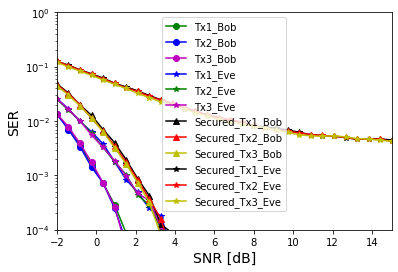

In [ ]:
# PLOTTING BER FOR BOB AND EVE AFTER SECURED TRAINING

plt.semilogy(bber_data_bob[0], bber_data_bob[1], 'go-')
plt.semilogy(bber_data_bob_2[0], bber_data_bob_2[1], 'bo-')
plt.semilogy(bber_data_bob_3[0], bber_data_bob_3[1], 'mo-')

plt.semilogy(bber_data_eve[0], bber_data_eve[1], 'b*-')
plt.semilogy(bber_data_eve_2[0], bber_data_eve_2[1], 'g*-')
plt.semilogy(bber_data_eve_3[0], bber_data_eve_3[1], 'm*-')

plt.semilogy(bber_sec_data_bob[0], bber_sec_data_bob[1], 'k^-')
plt.semilogy(bber_sec_data_bob_2[0], bber_sec_data_bob_2[1], 'r^-')
plt.semilogy(bber_sec_data_bob_3[0], bber_sec_data_bob_3[1], 'y^-')

plt.semilogy(bber_sec_data_eve[0], bber_sec_data_eve[1], 'k*-')
plt.semilogy(bber_sec_data_eve_2[0], bber_sec_data_eve_2[1], 'r*-')
plt.semilogy(bber_sec_data_eve_3[0], bber_sec_data_eve_3[1], 'y*-')

plt.gca().set_ylim(1e-4, 1)
plt.gca().set_xlim(-2, 15)

plt.xlabel('SNR [dB]', fontsize = 14)
plt.ylabel('SER', fontsize = 14, rotation=90)

# Plots one the transmitters w.r.t to Bob and Eve for Both Secured and unsecured  

plt.legend(['Tx1_Bob', 'Tx2_Bob', 'Tx3_Bob', 'Tx1_Eve', 'Tx2_Eve', 'Tx3_Eve', 'Secured_Tx1_Bob', 'Secured_Tx2_Bob', 'Secured_Tx3_Bob', 'Secured_Tx1_Eve', 'Secured_Tx2_Eve', 'Secured_Tx3_Eve'],prop={'size': 10}, loc='best');

In [ ]:
# TRAINING 3 INPUTS TOGETHER Bob

def train_both_inputs_bob_2(n_epochs=5, n_steps=20, alpha1=0.5, alpha2=0.5, alpha3=0.5, plot_encoding=True, only_decoder = False):
    for epoch in range(1, n_epochs+1):
       
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)
            X_batch_3 = random_batch(data_oneH_3, batch_size)

            with tf.GradientTape() as tape:
                y_pred_1 = autoencoderinput_1(X_batch_1, training=True)
                y_pred_2 = autoencoderinput_2(X_batch_2, training=True)
                y_pred_3 = autoencoderinput_3(X_batch_3, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))
                loss_3 = tf.reduce_mean(loss_fn(X_batch_3, y_pred_3))

                loss_eqn = alpha1*loss_1 + alpha2*loss_2 + alpha3*loss_3 
               
            
            if only_decoder: 
                gradients = tape.gradient(loss_eqn, decoder_bob_2.trainable_variables)
                optimizer.apply_gradients(zip(gradients, decoder_bob_2.trainable_variables))

            else: 
                 gradient = tape.gradient(loss_eqn, autoencoderinput_1.trainable_variables + autoencoderinput_2.trainable_variables + autoencoderinput_3.trainable_variables)
                 optimizer.apply_gradients(zip(gradient, autoencoderinput_1.trainable_variables + autoencoderinput_2.trainable_variables + autoencoderinput_3.trainable_variables))
              
            mean_loss = (loss_eqn)
            
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)

In [ ]:
# TRAINING 3 INPUTS TOGETHER EVE

def train_both_inputs_eve_2(n_epochs=5, n_steps=20, plot_encoding=True, alpha1=0.5, alpha2=0.5, alpha3=0.5):
    for epoch in range(1, n_epochs+1):
        print('Training Both inputs in Epochs {}/{}'.format(epoch, n_epochs))

        
        for step in range(1, n_steps+1):
            X_batch_1 = random_batch(data_oneH, batch_size)
            X_batch_2 = random_batch(data_oneH_2, batch_size)
            X_batch_3 = random_batch(data_oneH_3, batch_size)

            with tf.GradientTape() as tape:                
                y_pred_1 = autoencodereve_1(X_batch_1, training=True)
                y_pred_2 = autoencodereve_2(X_batch_2, training=True)
                y_pred_3 = autoencodereve_3(X_batch_3, training=True)

                loss_1 = tf.reduce_mean(loss_fn(X_batch_1, y_pred_1))
                loss_2 = tf.reduce_mean(loss_fn(X_batch_2, y_pred_2))
                loss_3 = tf.reduce_mean(loss_fn(X_batch_3, y_pred_3))

                loss_eqn = alpha1*loss_1 + alpha2*loss_2 + alpha3*loss_3 


            gradients = tape.gradient(loss_eqn, decoder_eve_2.trainable_variables)
            optimizer.apply_gradients(zip(gradients, decoder_eve_2.trainable_variables))


            mean_loss = (loss_eqn)
            plot_loss(step, epoch, mean_loss, X_batch_1, y_pred_1, plot_encoding)

In [ ]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve (ENCODER 1)

def Test2_AE(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_1.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob_2.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve_2.predict(rcvd_word_eve)

        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)

In [ ]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve (ENCODER 2)

def Test2_AE_2(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_2 = [None] * len(snr_range)
    bber_vec_eve_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_2.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob_2.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve_2.predict(rcvd_word_eve)

        bber_vec_bob_2[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_2[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob_2), (snr_range, bber_vec_eve_2)

In [ ]:
# Calculate BER FOR EVERY SNR. FEED TEST DATA TO TRAINED AE both Bob and Eve (ENCODER 2)

def Test2_AE_3(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_3 = [None] * len(snr_range)
    bber_vec_eve_3 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(5)
        code_word = encoder_3.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob_2.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve_2.predict(rcvd_word_eve)

        bber_vec_bob_3[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_3[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob_3), (snr_range, bber_vec_eve_3)

Training Both inputs in Epochs 1/5
Iteration: 100, Epoch: 1, Loss: 4.29060, Batch_BER: 0.04000


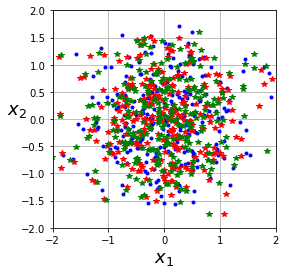

Training Both inputs in Epochs 2/5
Iteration: 100, Epoch: 2, Loss: 3.46934, Batch_BER: 0.05000


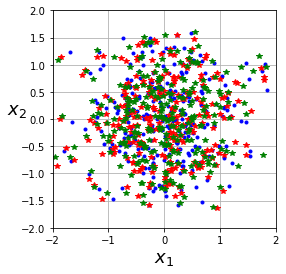

Training Both inputs in Epochs 3/5
Iteration: 100, Epoch: 3, Loss: 4.21686, Batch_BER: 0.00500


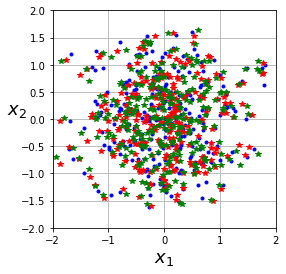

Training Both inputs in Epochs 4/5
Iteration: 100, Epoch: 4, Loss: 2.28088, Batch_BER: 0.01000


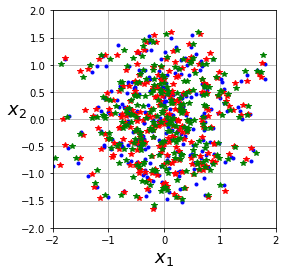

Training Both inputs in Epochs 5/5
Iteration: 100, Epoch: 5, Loss: 4.09953, Batch_BER: 0.02500


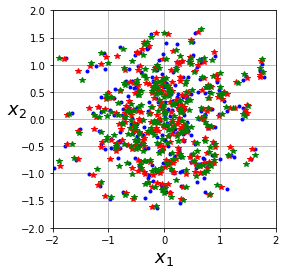

Training Both inputs in Epochs 1/5
Iteration: 100, Epoch: 1, Loss: 3.64188, Batch_BER: 0.07500


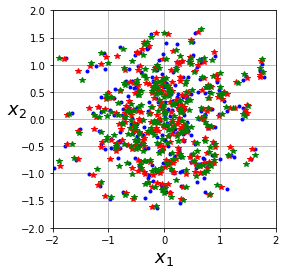

Training Both inputs in Epochs 2/5
Iteration: 100, Epoch: 2, Loss: 3.39697, Batch_BER: 0.06500


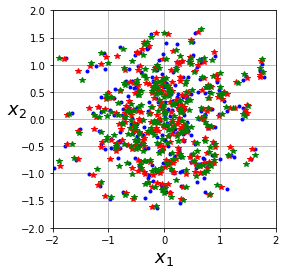

Training Both inputs in Epochs 3/5
Iteration: 100, Epoch: 3, Loss: 2.57022, Batch_BER: 0.06500


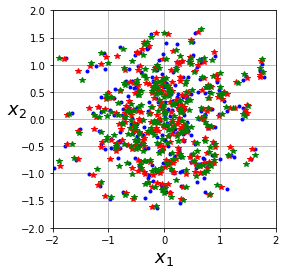

Training Both inputs in Epochs 4/5
Iteration: 100, Epoch: 4, Loss: 3.07615, Batch_BER: 0.06000


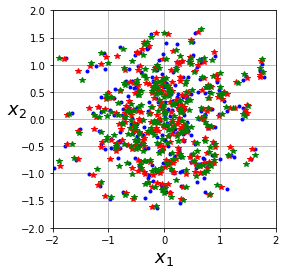

Training Both inputs in Epochs 5/5
Iteration: 100, Epoch: 5, Loss: 3.45306, Batch_BER: 0.07000


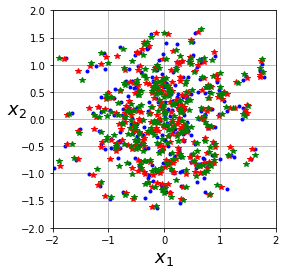

In [ ]:
#TRAINING BOB AND EVE AND TESTING

# train_both_setups_2(n_epochs, n_steps=20, alpha=0.5,  plot_encoding=False, only_decoder = False)

train_both_inputs_bob_2(n_epochs, n_steps, alpha1=10, alpha2=10, alpha3=10, plot_encoding = True, only_decoder = False)
train_both_inputs_eve_2(n_epochs, n_steps, plot_encoding = True, alpha1=5, alpha2=5, alpha3=5)
bber_data2_bob, bber_data2_eve = Test2_AE(data_normal)
bber_data2_bob_2, bber_data2_eve_2 = Test2_AE_2(data_normal_2)
bber_data2_bob_3, bber_data2_eve_3 = Test2_AE_3(data_normal_3)


In [ ]:
# SECURED TRAINING FOR MULTIPLE INPUTS (2)

def train_Secure_2(kmeans_labels, kmeans2_labels, kmeans3_labels, n_epochs=5, n_steps=20, eps1=0.7, eps2=0.7, beta1=0.7, beta2=0.7, beta3=0.7, gamma1=0.2, gamma2=0.2, gamma3=0.2, plot_encoding=True):

    sec_matrix = secure_matrix(kmeans_labels, groups=4, M=16)
    sec_matrix2 = secure_matrix2(kmeans2_labels, groups=4, M=16)
    sec_matrix3 = secure_matrix3(kmeans3_labels, groups=4, M=16)

    for epoch in range(1, n_epochs+1):
        print('Trainig for Secrecy in Epochs: {}/{}'.format(epoch, n_epochs))
        
        for step in range(1, n_steps+1):
            x_batch_1 = random_batch(data_oneH, batch_size)
            x_batch_s_1 = tf.matmul(x_batch_1, sec_matrix)

            x_batch_2 = random_batch(data_oneH_2, batch_size)
            x_batch_s_2 = tf.matmul(x_batch_2, sec_matrix2)

            x_batch_3 = random_batch(data_oneH_3, batch_size)
            x_batch_s_3 = tf.matmul(x_batch_3, sec_matrix3)

            with tf.GradientTape() as tape:
                y_pred_bob_1 = autoencoderinput_1(x_batch_1, training=True)
                y_pred_eve_1 = autoencodereve_1(x_batch_s_1, training=True)

                y_pred_bob_2 = autoencoderinput_2(x_batch_2, training=True)
                y_pred_eve_2 = autoencodereve_2(x_batch_s_2, training=True)

                y_pred_bob_3 = autoencoderinput_3(x_batch_3, training=True)
                y_pred_eve_3 = autoencodereve_3(x_batch_s_3, training=True)

                loss_bob_1 = tf.reduce_mean(loss_fn(x_batch_1, y_pred_bob_1))    
                loss_eve_1 = tf.reduce_mean(loss_fn(x_batch_s_1, y_pred_eve_1))

                loss_bob_2 = tf.reduce_mean(loss_fn(x_batch_2, y_pred_bob_2))
                loss_eve_2 = tf.reduce_mean(loss_fn(x_batch_s_2, y_pred_eve_2))

                loss_bob_3 = tf.reduce_mean(loss_fn(x_batch_3, y_pred_bob_3))
                loss_eve_3 = tf.reduce_mean(loss_fn(x_batch_s_3, y_pred_eve_3))

                loss_sec =  (eps1)*(beta1*loss_bob_1 + beta2*loss_bob_2 + beta3*loss_bob_3) + eps2*(gamma1*loss_eve_1 + gamma2*loss_eve_2 + gamma3*loss_eve_3)

            gradients = tape.gradient(loss_sec, autoencoderinput_1.trainable_variables + autoencoderinput_2.trainable_variables + autoencoderinput_3.trainable_variables) 
            optimizer.apply_gradients(zip(gradients, autoencoderinput_1.trainable_variables + autoencoderinput_2.trainable_variables + autoencoderinput_3.trainable_variables)) 

            mean_loss(loss_sec)
            plot_loss(step, epoch, mean_loss, x_batch_1, y_pred_bob_1, plot_encoding)

In [ ]:
# Used to Calculate BER FOR EVERY SNR AFTER SECURED TRAINING (encoder_1)
def Test2_Secure_AE(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob = [None] * len(snr_range)
    bber_vec_eve = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(1)
        code_word = encoder_1.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob_2.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve_2.predict(rcvd_word_eve)

        bber_vec_bob[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob), (snr_range, bber_vec_eve)

In [ ]:
# Used to Calculate BER FOR EVERY SNR AFTER SECURED TRAINING (encoder_2)

def Test2_Secure_AE_2(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_2 = [None] * len(snr_range)
    bber_vec_eve_2 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(1)
        code_word = encoder_2.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob_2.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve_2.predict(rcvd_word_eve)

        bber_vec_bob_2[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_2[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob_2), (snr_range, bber_vec_eve_2)

In [ ]:
def Test2_Secure_AE_3(data):
    snr_range = np.linspace(-2, 15, 30)
    bber_vec_bob_3 = [None] * len(snr_range)
    bber_vec_eve_3 = [None] * len(snr_range)

    for db in range(len(snr_range)):
        noise_std = snr_to_noise(snr_range[db])
        noise_std_eve = snr_to_noise(1)
        code_word = encoder_3.predict(data)

        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std) #Bob
        rcvd_word_eve = rcvd_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std_eve) #Eve

        dcoded_msg_bob = decoder_bob_2.predict(rcvd_word)
        dcoded_msg_eve = decoder_eve_2.predict(rcvd_word_eve)

        bber_vec_bob_3[db] = B_Ber(data, dcoded_msg_bob)
        bber_vec_eve_3[db] = B_Ber(data, dcoded_msg_eve)

    #test_noisy_codeword(rcvd_word)
    #test_noisy_codeword(rcvd_word_eve)

    return (snr_range, bber_vec_bob_3), (snr_range, bber_vec_eve_3)

In [ ]:
#TRAINING BOB AND EVE AND TESTING ~ USING modified KMEANS 

kmeans = new_kmeans(M, groups,n)
kmeans2 = new_kmeans2(M, groups, n)
kmeans3 = new_kmeans3(M, groups, n)

#train_Secure_2(kmeans.labels_, kmeans2.labels_, n_epochs-3, n_steps=20, eps=0.9, beta=0.6, gamma=0.8, plot_encoding=True) # Initial values were 0.9, 0.8, 0.8 beta at 0.6 was pretty cool
train_Secure_2(kmeans.labels_, kmeans2.labels_, kmeans3.labels_, n_epochs, n_steps=20, eps1=1, eps2=15, beta1=5, beta2=5, beta3=5, gamma1=10, gamma2=10, gamma3=10, plot_encoding=True)

train_both_inputs_bob_2(n_epochs-2, n_steps, alpha1=10, alpha2=10, alpha3=10, plot_encoding = False, only_decoder = True)
train_both_inputs_eve_2(n_epochs-3, n_steps, plot_encoding = True, alpha1=5, alpha2=5, alpha3=5)

bber_sec_data2_bob, bber_sec_data2_eve = Test2_Secure_AE(data_normal)
bber_sec_data2_bob_2, bber_sec_data2_eve_2 = Test2_Secure_AE_2(data_normal_2)
bber_sec_data2_bob_3, bber_sec_data2_eve_3 = Test2_Secure_AE_3(data_normal_3)

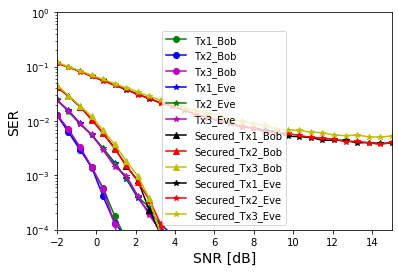

In [ ]:
# PLOTTING BER FOR BOB AND EVE AFTER SECURED TRAINING

plt.semilogy(bber_data2_bob[0], bber_data2_bob[1], 'go-')
plt.semilogy(bber_data2_bob_2[0], bber_data2_bob_2[1], 'bo-')
plt.semilogy(bber_data2_bob_3[0], bber_data2_bob_3[1], 'mo-')

plt.semilogy(bber_data2_eve[0], bber_data2_eve[1], 'b*-')
plt.semilogy(bber_data2_eve_2[0], bber_data2_eve_2[1], 'g*-')
plt.semilogy(bber_data2_eve_3[0], bber_data2_eve_3[1], 'm*-')

plt.semilogy(bber_sec_data2_bob[0], bber_sec_data2_bob[1], 'k^-')
plt.semilogy(bber_sec_data2_bob_2[0], bber_sec_data2_bob_2[1], 'r^-')
plt.semilogy(bber_sec_data2_bob_3[0], bber_sec_data2_bob_3[1], 'y^-')

plt.semilogy(bber_sec_data2_eve[0], bber_sec_data2_eve[1], 'k*-')
plt.semilogy(bber_sec_data2_eve_2[0], bber_sec_data2_eve_2[1], 'r*-')
plt.semilogy(bber_sec_data2_eve_3[0], bber_sec_data2_eve_3[1], 'y*-')

plt.gca().set_ylim(1e-4, 1)
plt.gca().set_xlim(-2, 15)

plt.xlabel('SNR [dB]', fontsize = 14)
plt.ylabel('SER', fontsize = 14, rotation=90)

# Plots one the transmitters w.r.t to Bob and Eve for Both Secured and unsecured  

plt.legend(['Tx1_Bob', 'Tx2_Bob', 'Tx3_Bob', 'Tx1_Eve', 'Tx2_Eve', 'Tx3_Eve', 'Secured_Tx1_Bob', 'Secured_Tx2_Bob', 'Secured_Tx3_Bob', 'Secured_Tx1_Eve', 'Secured_Tx2_Eve', 'Secured_Tx3_Eve'],prop={'size': 10}, loc='best');

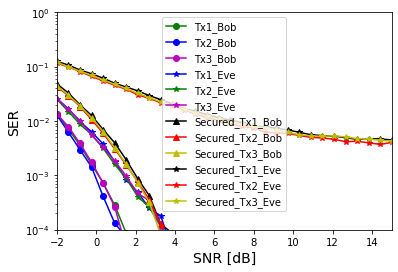

In [ ]:
plt.semilogy(bber_data_bob[0], bber_data_bob[1], 'go-')
plt.semilogy(bber_data2_bob_2[0], bber_data2_bob_2[1], 'bo-')
plt.semilogy(bber_data_bob_3[0], bber_data_bob_3[1], 'mo-')

plt.semilogy(bber_data_eve[0], bber_data_eve[1], 'b*-')
plt.semilogy(bber_data2_eve_2[0], bber_data2_eve_2[1], 'g*-')
plt.semilogy(bber_data_eve_3[0], bber_data_eve_3[1], 'm*-')

plt.semilogy(bber_sec_data_bob[0], bber_sec_data_bob[1], 'k^-')
plt.semilogy(bber_sec_data2_bob_2[0], bber_sec_data2_bob_2[1], 'r^-')
plt.semilogy(bber_sec_data_bob_3[0], bber_sec_data_bob_3[1], 'y^-')

plt.semilogy(bber_sec_data_eve[0], bber_sec_data_eve[1], 'k*-')
plt.semilogy(bber_sec_data2_eve_2[0], bber_sec_data2_eve_2[1], 'r*-')
plt.semilogy(bber_sec_data_eve_3[0], bber_sec_data_eve_3[1], 'y*-')

plt.gca().set_ylim(1e-4, 1)
plt.gca().set_xlim(-2, 15)

plt.xlabel('SNR [dB]', fontsize = 14)
plt.ylabel('SER', fontsize = 14, rotation=90)
plt.legend(['Tx1_Bob', 'Tx2_Bob', 'Tx3_Bob', 'Tx1_Eve', 'Tx2_Eve', 'Tx3_Eve', 'Secured_Tx1_Bob', 'Secured_Tx2_Bob', 'Secured_Tx3_Bob', 'Secured_Tx1_Eve', 'Secured_Tx2_Eve', 'Secured_Tx3_Eve'],prop={'size': 10}, loc='best');

In [ ]:
#import csv 
#with open('/content/drive/MyDrive/Colab Notebooks/Completed ~ DL PhySec/Final codes/Reviewers simulation/ File5b.csv', 'w', newline='') as file:
#    writer = csv.writer(file) 
#    writer.writerow(['SNR', 'unsecured TX_1_Bob', 'unsecured TX_2_Bob', 'unsecured TX_3_Bob', 'unsecured TX1_Eve','unsecured TX2_Eve','unsecured TX3_Eve', 'secured TX1_Bob', 'secured TX2_Bob', 'secured TX3_Bob', 'secured TX1_Eve', 'secured TX2_Eve', 'secured TX3_Eve'])
   
#    for i in range(30):
#      writer.writerow([bber_data_bob[0][i], np.array(bber_data_bob[1][i]), np.array(bber_data2_bob_2[1][i]), np.array(bber_data_bob_3[1][i]), np.array(bber_data_eve[1][i]), np.array(bber_data2_eve_2[1][i]), np.array(bber_data_eve_3[1][i]), np.array(bber_sec_data_bob[1][i]), np.array(bber_sec_data2_bob_2[1][i]), np.array(bber_sec_data_bob_3[1][i]), np.array(bber_sec_data_eve[1][i]), np.array(bber_sec_data2_eve_2[1][i]), np.array(bber_sec_data_eve_3[1][i])])
